# TME4 - Perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from data.mltools import plot_data, plot_frontiere, make_grid, gen_arti
from sklearn.model_selection import cross_val_score,train_test_split


In [2]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.figure()
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="hot")
    plt.colorbar()



In [3]:
def proj_poly(X):
    n, d = X.shape
    dP = int(1 + 2*d + (d *(d-1)/2))
    XP = np.zeros((n, dP))
    XP[:, 0] = 1
    k = 2*d
    for j in range(d):
        XP[:, j+1] = X[:, j]
        XP[:, j+1+d] = X[:, j]**2
        for i in range(j+1,d):
            k += 1
            XP[:, k] = X[:, j] * X[:, i]
    return XP

def proj_biais(X):
    return np.append(X, np.ones((len(X), 1)),axis=1)

def proj_gauss(X, base, sigma):
    assert X.shape[1] == base.shape[1]
    return np.array([(((x - base)**2).sum(1) / 2*sigma) for x in X])

## Perceptron et classe Linéaire

Implémentez la fonction perceptron_loss(w,x,y) qui rend le coût perceptron (max(0, −y < x.w >)
et son gradient perceptron_grad(w,x,y).
Afin d’être plus générique et plus flexible, plutôt que d’implémenter une version script de la descente
de gradient, nous allons coder une classe Lineaire qui va regrouper les différentes variantes possibles.
Un squelette de classe est fourni dans le fichier source : il contient principalement le constructeur qui
initialise les paramètres du modèle (le coût utilisé loss, son gradient loss_g, le nombre d’itération
de la descente du gradient max_iter, le pas eps, le vecteur de poids w). Complétez le squelette en
implémentant :
- la méthode predict(self,datax) qui permet d’inférer le label des données datax (i.e. qui calcule sign(< w.x >))
- la méthode score(self,datax,datay) qui permet de calculer le pourcentage de bonne classification sur le jeu de données passé en paramètre.
- la méthode fit(self,datax,datay) permet de faire la descente de gradient pendant max_iter itérations avec un pas eps en utilisant le coût loss et le gradient loss_g. Ainsi pour faire un perceptron, il suffira de passer lors de la construction de l’objet le coût et le gradient du coût perceptron. Votre méthode devra également conserver en mémoire l’historique des coûts en fonction des itérations.

Comme dans le précédent TME, vos méthodes doivent prendre en entrée des matrices de données (et
non pas une seule donnée). Testez votre classe sur l’exemple de la semaine dernière.

In [4]:
def perceptron_loss(w,x,y):
    """
    array**3 -> float
    x : n lignes, d colonnes
    w : d lignes, 1 colonne
    y : n lignes, 1 colonne
    Retourne le cout perceptron (hinge-loss)
    """
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return np.maximum(0,-y*(x@w))

def perceptron_grad(w,x,y):
    """
    array**3 -> float
    x : n lignes, d colonnes
    w : d lignes, 1 colonne
    y : n lignes, 1 colonne
    Retourne le cout du gradient du perceptron (gradient du hinge-loss)
    """
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return np.where((-y*x)*perceptron_loss(w,x,y) < 0, 0, -y*x)
    

In [5]:
class Lineaire(object):
    def __init__(self,loss=perceptron_loss,loss_g=perceptron_grad,max_iter=100,eps=0.01):
        self.max_iter, self.eps = max_iter,eps
        self.w = None
        self.loss,self.loss_g = loss,loss_g
        
    def fit(self,datax,datay):
        couts = []
        self.w = np.random.randn(datax.shape[1],1)
        datay = datay.reshape(-1,1)
        
        for i in range(self.max_iter):
            self.w = self.w - self.eps * self.loss_g(self.w,datax,datay).mean(axis=0).reshape(-1,1)
            couts.append(self.loss(self.w,datax,datay).sum())

        return couts

    def predict(self,datax):
        return np.sign(datax@self.w)

    def score(self,datax,datay):
        y = self.predict(datax).reshape(-1)
        return (y==datay).mean()


## Données USPS

Les données USPS sont des données de chiffres manuscrits représentés par une matrice de pixel en
niveau de gris de taille 16 × 16. Le code pour les charger vous est fourni ainsi qu’une fonction de
visualisation (load_usps et show_usps).
Chargez les données et visualisez quelques exemples. Isolez 2 classes (par exemple les 6 vs 9 ) et entraînez
un perceptron dessus. Visualisez la matrice de poids obtenue à l’aide de la fonction show_usps. Que
remarquez vous ? Comment interpréter le résultat ?
Observez la matrice de poids obtenue lorsque vous entraînez le perceptron avec une classe (6 par
exemple) contre toutes les autres classes.
En utilisant les données de test, tracer les courbes d’erreurs en apprentissage et en test en fonction du
nombre d’itérations (vous pouvez modifier la fonction fit de la classe Linéraire afin qu’elle prenne
également des données test en entrée). Observez-vous du sur-apprentissage ?

In [6]:
uspsdatatrain = "./data/USPS_train.txt"
uspsdatatest = "./data/USPS_test.txt"
alltrainx,alltrainy = load_usps(uspsdatatrain)
alltestx,alltesty = load_usps(uspsdatatest)

### One vs. One


6 vs 4 :
score train = 0.5045592705167173
score test = 0.4594594594594595


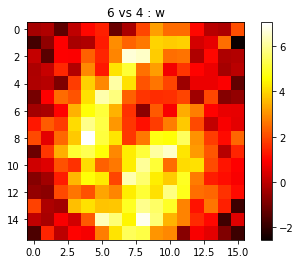

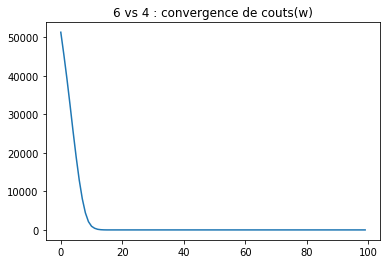

In [7]:
# 6 vs 4
pos,neg = 6,4
datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
testx,testy = get_usps([neg,pos],alltestx,alltesty)
datay_sign = np.where(datay==pos,1,-1)
testy_sign = np.where(testy==pos,1,-1)

L = Lineaire()

couts = L.fit(datax,datay)
show_usps(L.w)
plt.title(f"{pos} vs {neg} : w")

print(f"{pos} vs {neg} :")
print("score train =", L.score(datax,datay_sign))
print("score test =", L.score(testx,testy_sign))

plt.figure()
plt.plot(couts)
plt.title(f"{pos} vs {neg} : convergence de couts(w)")

plt.show()


Ici, on reconnait bien la forme du 6 dans la matrice de poids. En effet, le poids est plus elevé pour les pixels du 6 (plus généralement, du nombre dont l'annotation est 1).

Quand bien même le vecteur poids converge rapidement, les perfomances ne sont pas satisfaisantes avec 50% de reussits en apprentissage et 40% en test.

### One vs. All

6 vs all :
score train = 0.9089288163489233
score test = 0.9152964623816642


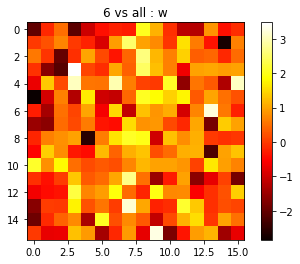

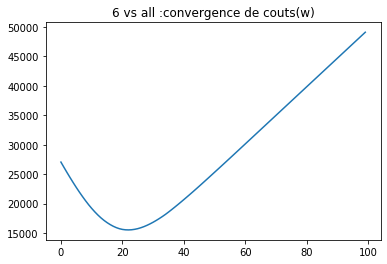

In [8]:
# 6 vs all
neg = 6
pos = [i for i in range(10) if i != neg]
datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
testx,testy = get_usps([neg,pos],alltestx,alltesty)
datay_sign = np.where(datay==neg,-1,1)
testy_sign = np.where(testy==neg,-1,1)

L = Lineaire()

couts = L.fit(datax,datay_sign)
show_usps(L.w)
plt.title(f"{neg} vs all : w")

print(f"{neg} vs all :")
print("score train =", L.score(datax,datay_sign))
print("score test =", L.score(testx,testy_sign))

plt.figure()
plt.plot(couts)
plt.title(f"{neg} vs all :convergence de couts(w)")

plt.show()

Ici, la matrice de poids a visuellement moins de sens mais cela a en fait permis d'eviter l'overfitting. On obtient donc de bien meilleurs résultats avec entre 90% et 91% de taux de reussite en apprentissage et en test.

## Mini-batch et descente stochastique

Modifiez votre méthode fit afin de pouvoir faire une descente stochastique (les exemples sont ordonnés
aléatoirement et un seul exemple est pris en compte lors du calcul du gradient et de la mise-à-jour des
poids) et mini-batch (l’ensemble des exemples est divisé en petits batchs aléatoire de m exemples, le
gradient est moyenné sur chaque batch avant de faire la mise-à-jour). Afin de comparer équitablement les différentes variantes, le paramètre max_iter dénotera le nombre d’époques et non le nombre de
mise-à-jour du gradient (une époque étant le fait d’avoir vu une fois tous les exemples). Vous pouvez
remarquer que la descente stochastique correspond à une descente mini-batch de taille 1, et une descente
batch à une descente mini-batch de taille le nombre d’exemples.
Comparez la vitesse de convergence en particulier en fonction du bruit dans le jeu de données.

In [9]:
class Lineaire_bis(object):
    def __init__(self, loss=perceptron_loss,loss_g=perceptron_grad, max_iter=100, eps=1e-2, 
                projection=None, args_proj={},gradient_mode=0,batch_size=100):
        self.max_iter = max_iter
        self.eps = eps
        self.loss = loss
        self.loss_g = loss_g
        self.all_w                  = []
        self.loss_values            = []
        self.accuracy_values        = []
        self.w = None    
       
        self.projection = projection
        if projection == proj_gauss:
            self.projection = lambda X: proj_gauss(X, **args_proj)
        
        self.gradient_mode  = gradient_mode
        self.batch_size     = batch_size
        if self.gradient_mode == 0:
            self.batch_size = 1


        
    def fit(self, X, Y):
        X_proj = X
        if self.projection is not None:
            X_proj = self.projection(X)
            X_test_proj = self.projection(X_test)

        self.w = .001 * np.ones((X_proj.shape[1], 1))
        self.all_w = [self.w]

        self.loss_values = [self.loss(self.w, X_proj, Y).mean()]
        self.accuracy_values = [self.score(X, Y)]

        N = len(X)
        for _ in range(self.max_iter):

            # Mini batch : m , stochastic : 1
            if self.gradient_mode == 1 or self.gradient_mode == 2:
                idx = np.random.choice(N, self.batch_size)
                X_batch = X_proj[idx]
                Y_batch = Y[idx]

            # Batch : N
            else:
                X_batch = X_proj
                Y_batch = Y

            self.w -= self.eps * self.loss_g(self.w, X_batch, Y_batch).mean(0).reshape(-1,1)
            self.all_w.append(self.w)

            self.loss_values.append(self.loss(self.w, X_proj, Y).mean())
            self.accuracy_values.append(self.score(X, Y))

    def predict(self, X):
        if self.projection is not None:
            X = self.projection(X)
        return np.sign(X @ self.w)

    def score(self, X, Y):
        Y_pred = self.predict(X)
        return np.where(Y_pred == Y, 1, 0).mean()



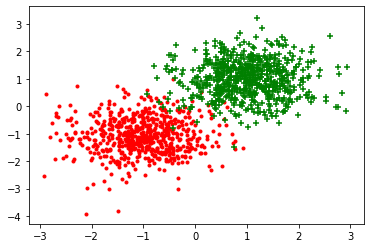

In [10]:
X, Y = gen_arti(nbex=1250, data_type=0, epsilon=.6)
plot_data(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)


### Batch

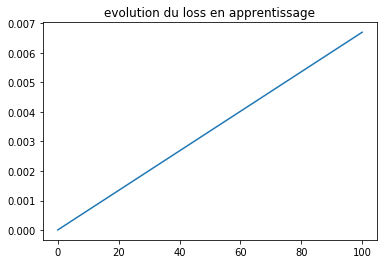

In [11]:
modele_batch = Lineaire_bis(gradient_mode = 0)
modele_batch.fit(X_train, Y_train)
plt.plot(modele_batch.loss_values)
plt.title('evolution du loss en apprentissage')
plt.show()

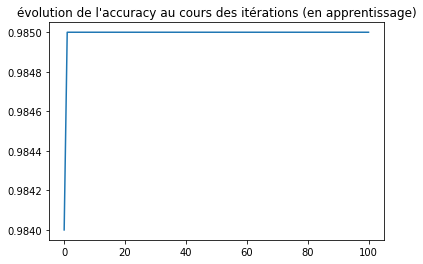

In [12]:
plt.plot(modele_batch.accuracy_values)
plt.title("évolution de l'accuracy au cours des itérations (en apprentissage)")
plt.show()

In [13]:
print("score final sur train", modele_batch.score(X_train, Y_train))
print("score final sur test", modele_batch.score(X_test, Y_test))

score final sur train 0.985
score final sur test 0.968


### Mini-Batch

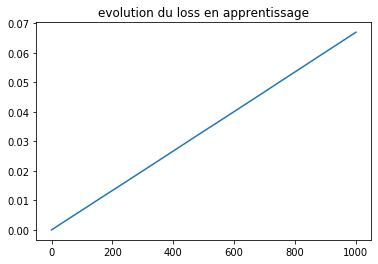

In [14]:
modele_minibatch = Lineaire_bis(max_iter = 1000, gradient_mode = 1)
modele_minibatch.fit(X_train, Y_train)
plt.plot(modele_minibatch.loss_values)
plt.title('evolution du loss en apprentissage')
plt.show()

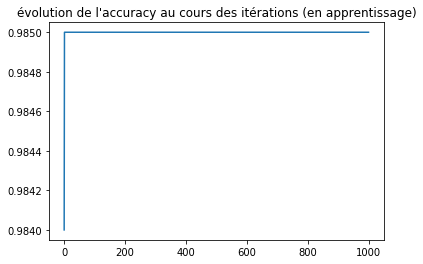

In [15]:
plt.plot(modele_minibatch.accuracy_values)
plt.title("évolution de l'accuracy au cours des itérations (en apprentissage)")
plt.show()

In [16]:
print("score final sur train", modele_minibatch.score(X_train, Y_train))
print("score final sur test", modele_minibatch.score(X_test, Y_test))

score final sur train 0.985
score final sur test 0.968


### Stochastique

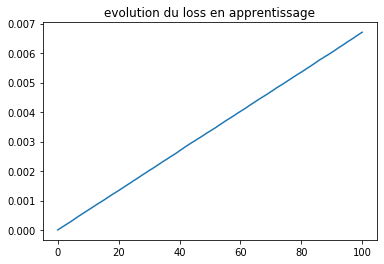

In [17]:
modele_stoch = Lineaire_bis(max_iter = 100, gradient_mode = 1)
modele_stoch.fit(X_train, Y_train)
plt.plot(modele_stoch.loss_values)
plt.title('evolution du loss en apprentissage')
plt.show()

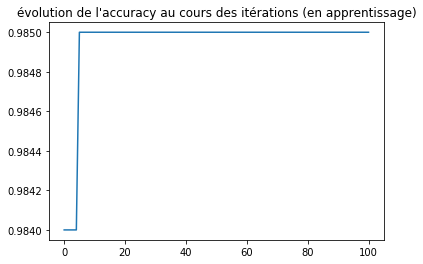

In [18]:
plt.plot(modele_stoch.accuracy_values)
plt.title("évolution de l'accuracy au cours des itérations (en apprentissage)")
plt.show()

In [19]:
print("score final sur train", modele_stoch.score(X_train, Y_train))
print("score final sur test", modele_stoch.score(X_test, Y_test))

score final sur train 0.985
score final sur test 0.968


## Projections et pénalisation

Afin d’augmenter l’expressivité du modèle linéaire, nous allons utiliser des projections. Codez la fonction proj_poly(datax) qui renvoie la projection polynomiale de degré 2 des données :

(1, x1, x2, . . . , xd, x2
1
, x1x2, . . . x2
d
).

Codez également la fonction proj_biais(datax) qui permet d’ajouter une colonne de 1 en première
colonne des données afin d’introduire un biais.
Modifiez votre constructeur pour qu’il prenne potentiellement une projection en paramètre, votre
fonction fit afin qu’elle projette si besoin les données avant de faire l’apprentissage, ainsi que votre
fonction predict.
Testez votre projection polynomiale sur les données artificielles de la fonction gen_arti de type 1 et 2. Tracez les frontières de décision.
Codez la fonction proj_gauss(datax,base,sigma) qui réalise une projection gaussienne de datax sur
les points (b1, . . . , bb) de bases avec un paramètre sigma : pour une donnée x de datax, sa représentation est (e
−∥x−b1∥
2/2σ
, e−∥x−b2∥
2/2σ
, . . . , e−∥x−bb∥
2/2σ
) et expérimentez sur les 3 jeu de données
artificiels. Vaut-il mieux beaucoup de points ou peu de points pour la base de projection ? Un grand
ou petit σ ? Quels sont les points qui ont le plus de poids ? Représentez les sur les figures et tracez les
frontières.
Vous pouvez également étudié l’effet d’une marge et d’une pénalisation sur les poids de la projection
gaussienne : introduisez une nouvelle fonction de coût hinge_loss(w,x,y,alpha,lambda) qui retourne
max(0, α−y < w.x >)+λ∥w∥
2
et son gradient hinge_loss_grad. Observez l’effet de alpha et lambda
en particulier sur le problème de l’échiquier.

### Projection biais - sur données USPS

In [20]:
pos,neg = 6,9
datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
testx,testy = get_usps([neg,pos],alltestx,alltesty)
datay_sign = np.where(datay==pos,1,-1)
testy_sign = np.where(testy==pos,1,-1)


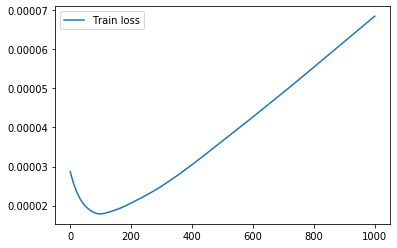

In [21]:
modele_biais= Lineaire_bis(max_iter=1_000, eps=1e-5, projection=proj_biais)
modele_biais.fit(X_train, Y_train)
plt.plot(modele_biais.loss_values, label='Train loss')
plt.legend()

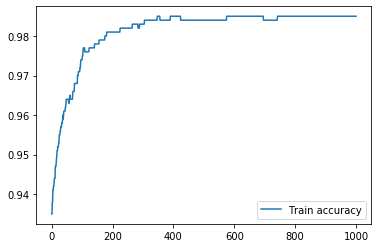

In [22]:
plt.plot(modele_biais.accuracy_values, label='Train accuracy')
plt.legend()

In [23]:
print('Accuracy en train :', modele_biais.score(X_train, Y_train))
print('Accuracy en test :', modele_biais.score(X_test, Y_test))

Accuracy en train : 0.985
Accuracy en test : 0.972


### Projection polynomial - sur données non séparables linéairement

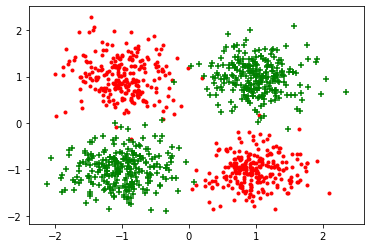

In [24]:
X, Y = gen_arti(nbex=1000, data_type=1, epsilon=0.2)
plot_data(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)


In [25]:
modele_poly = Lineaire_bis(max_iter=1_000, eps=1e-2, projection=proj_poly)
modele_poly.fit(X_train, Y_train)

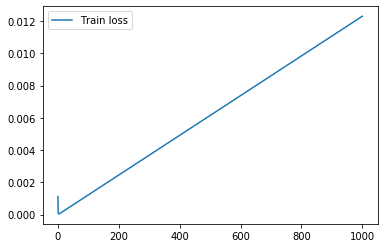

In [26]:
plt.plot(modele_poly.loss_values, label='Train loss')
plt.legend()

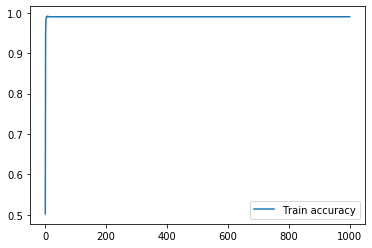

In [27]:
plt.plot(modele_poly.accuracy_values, label='Train accuracy')
plt.legend()

In [28]:
print('Accuracy en train :', modele_poly.score(X_train, Y_train))
print('Accuracy en test :', modele_poly.score(X_test, Y_test))

Accuracy en train : 0.99
Accuracy en test : 0.995


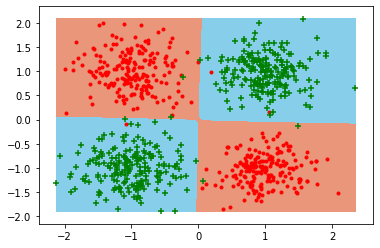

In [29]:
plot_frontiere(X_train, Y_train, modele_poly)
plot_data(X_train, Y_train)